# Visualise search process with high-dimensional problems




# Genetic programming for classification

Instead of evolving a regressor, GP is used to evolve classifier in this notebook. The GP configuration here is very similar to that for symbolic regression. And in this notebook, we also try to visualise the search process of GP.



In [1]:
!pip install deap
!pip install statannot
!pip install minisom
import random
import numpy
from deap import algorithms
from deap import base
from deap import creator
from deap import tools
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statannot import add_stat_annotation
sns.set()

     |████████████████████████████████| 163kB 3.5MB/s 
  Created wheel for minisom: filename=MiniSom-2.2.6-cp36-none-any.whl size=8525 sha256=4d828a5db2ab1c49bdbe60d29b1b0de6dd757a76e63d87cb66bafc246c6a3496
  Stored in directory: /root/.cache/pip/wheels/b8/c6/01/330066e36e1f7c826c96f656f9185822cfcdef0591315949ea
Successfully built minisom


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


For our experiments, we use the spambase dataset which include the textual features (e.g. frequency of words) and the goal is to predict which email is a spam. 

In [2]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/spambase/spambase.data
fnames = ["word_freq_make","word_freq_address","word_freq_all","word_freq_3d","word_freq_our","word_freq_over","word_freq_remove","word_freq_internet","word_freq_order","word_freq_mail","word_freq_receive","word_freq_will","word_freq_people","word_freq_report","word_freq_addresses","word_freq_free","word_freq_business","word_freq_email","word_freq_you","word_freq_credit","word_freq_your","word_freq_font","word_freq_000","word_freq_money","word_freq_hp","word_freq_hpl","word_freq_george","word_freq_650","word_freq_lab","word_freq_labs","word_freq_telnet","word_freq_857","word_freq_data","word_freq_415","word_freq_85","word_freq_technology","word_freq_1999","word_freq_parts","word_freq_pm","word_freq_direct","word_freq_cs","word_freq_meeting","word_freq_original","word_freq_project","word_freq_re","word_freq_edu","word_freq_table","word_freq_conference","char_freq_%3B","char_freq_%28","char_freq_%5B","char_freq_%21","char_freq_%24","char_freq_%23","capital_run_length_average","capital_run_length_longest","capital_run_length_total","class"]
df = pd.read_csv('spambase.data', header=None)
df.columns = fnames

--2020-06-22 00:50:13--  https://archive.ics.uci.edu/ml/machine-learning-databases/spambase/spambase.data
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 702942 (686K) [application/x-httpd-php]
Saving to: ‘spambase.data’

spambase.data       100%[===================>] 686.47K  3.71MB/s    in 0.2s    

2020-06-22 00:50:13 (3.71 MB/s) - ‘spambase.data’ saved [702942/702942]



In [3]:
spam = list(df.values)
nfeatures = len(df.columns) - 1

Different from symbolic regression, the outputs of the evolved classifiers are boolean, i.e. class label, instead of float. Fortunately, this can be easily done when defining the terminal set and function set with `deap`. To speed up the search process (anyway, our goal is not about accuracy in this tutorial), we use a subset of the `spambase` dateset for fitness evaluation.

In [4]:
import random
import operator
import csv
import itertools

import numpy

from deap import algorithms
from deap import base
from deap import creator
from deap import tools
from deap import gp

# Read the spam list features and put it in a list of lists.
# The dataset is from http://archive.ics.uci.edu/ml/datasets/Spambase
# This example is a copy of the OpenBEAGLE example :
# http://beagle.gel.ulaval.ca/refmanual/beagle/html/d2/dbe/group__Spambase.html
# with open("spambase.csv") as spambase:
#     spamReader = csv.reader(spambase)
#     spam = list(list(float(elem) for elem in row) for row in spamReader)

# defined a new primitive set for strongly typed GP
pset = gp.PrimitiveSetTyped("MAIN", itertools.repeat(float, nfeatures), bool, "IN")

# boolean operators
pset.addPrimitive(operator.and_, [bool, bool], bool)
pset.addPrimitive(operator.or_, [bool, bool], bool)
pset.addPrimitive(operator.not_, [bool], bool)

# floating point operators
# Define a protected division function
def protectedDiv(left, right):
    try: return left / right
    except ZeroDivisionError: return 1

pset.addPrimitive(operator.add, [float,float], float)
pset.addPrimitive(operator.sub, [float,float], float)
pset.addPrimitive(operator.mul, [float,float], float)
pset.addPrimitive(protectedDiv, [float,float], float)

# logic operators
# Define a new if-then-else function
def if_then_else(input, output1, output2):
    if input: return output1
    else: return output2

pset.addPrimitive(operator.lt, [float, float], bool)
pset.addPrimitive(operator.eq, [float, float], bool)
pset.addPrimitive(if_then_else, [bool, float, float], float)

# terminals
pset.addEphemeralConstant("randvll", lambda: random.random() * 100, float)
pset.addTerminal(False, bool)
pset.addTerminal(True, bool)

creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", gp.PrimitiveTree, fitness=creator.FitnessMax)

toolbox = base.Toolbox()
toolbox.register("expr", gp.genHalfAndHalf, pset=pset, min_=1, max_=2)
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.expr)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("compile", gp.compile, pset=pset)

def evalSpambase(individual):
    # Transform the tree expression in a callable function
    func = toolbox.compile(expr=individual)
    # Randomly sample 400 mails in the spam database
    spam_samp = random.sample(spam, 1000)
    # Evaluate the sum of correctly identified mail as spam
    result = sum(bool(func(*mail[:nfeatures])) is bool(mail[nfeatures]) for mail in spam_samp)
    return result,

maxdepth=10
toolbox.register("evaluate", evalSpambase)
toolbox.register("select", tools.selTournament, tournsize=3)
toolbox.register("mate", gp.cxOnePoint)
toolbox.register("expr_mut", gp.genFull, min_=0, max_=2)
toolbox.register("mutate", gp.mutUniform, expr=toolbox.expr_mut, pset=pset)
toolbox.decorate("mate", gp.staticLimit(key=operator.attrgetter("height"), max_value=maxdepth))
toolbox.decorate("mutate", gp.staticLimit(key=operator.attrgetter("height"), max_value=maxdepth))

The search algorithm here is similar to that for symbolic regression. For the phenotype, we use the prediction outputs for some pre-determined instances `pheno_sample`.

In [5]:
def run_monitor_gp(seed, popsize, ngen, mutateprob, crossprob, pheno_sample):
  random.seed(seed)
  np.random.seed(seed)    
  records = []
  stats = tools.Statistics(key=lambda ind: ind.fitness.values)
  stats.register("avg", numpy.mean)
  stats.register("std", numpy.std)
  stats.register("min", numpy.min)
  stats.register("max", numpy.max)
  pop = toolbox.population(n=popsize)
  CXPB, MUTPB, NGEN = crossprob, mutateprob, ngen

  # Evaluate the entire population
  fitnesses = map(toolbox.evaluate, pop)
  for ind, fit in zip(pop, fitnesses):
      ind.fitness.values = fit

  for g in range(NGEN):
      # Select the next generation individuals
      offspring = toolbox.select(pop, len(pop))
      # Clone the selected individuals
      offspring = list(map(toolbox.clone, offspring))
      # Apply crossover and mutation on the offspring        
      offspring = algorithms.varAnd(offspring, toolbox, CXPB, MUTPB)

      # Evaluate the individuals with an invalid fitness
      invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
      fitnesses = map(toolbox.evaluate, invalid_ind)
      for ind, fit in zip(invalid_ind, fitnesses):
          ind.fitness.values = fit
      record = stats.compile(pop)
      print("Gen#{}\t{:8.2f}\t{:8.2f}\t{:8.2f}".format(g, record["min"], record["avg"], record["max"]))
      # records.append([g, record["min"], record["avg"], record["max"]])
      # The population is entirely replaced by the offspring
      # [bool(toolbox.compile(expr=pop[i])(*mail[:nfeatures])) is bool(mail[nfeatures]) for mail in pheno_sample]
      for i in range(len(offspring)):
          func = toolbox.compile(expr=pop[i])
          records.append([g, i, pop[i].fitness.values[0], toolbox.clone(pop[i])] + [int(bool(func(*mail[:nfeatures])) is bool(mail[nfeatures])) for mail in pheno_sample])

      # topind = tools.selBest(pop, 1)
      # pop = tools.selBest(offspring + topind, len(pop))
      pop[:] = offspring
  return records

In [6]:
def visualise_dimension_reduction(embedding, df):
  plt.subplots(figsize=(10,6))
  plt.scatter(embedding[:,0], embedding[:,1], c=df["gen"], cmap="winter",
              s=10 + 40*(1-(df["fitness"] - df["fitness"].min())/(df["fitness"].max() - df["fitness"].min())), alpha=0.5)
  plt.colorbar()

Determine the GP parameters and run the experiment. It may takes several minutes.

In [7]:
toolbox.register("select", tools.selTournament, tournsize=5)
pheno_sample=random.sample(spam, 100)
outputs = np.array(run_monitor_gp(1, 1000, 50, 0.1, 0.9, pheno_sample))
outputs.shape
df = pd.DataFrame(outputs, columns=["gen","id","fitness","prog"] + ["p{}".format(i+1) for i in range(len(pheno_sample))])
df.tail()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:33: RuntimeWarning: divide by zero encountered in double_scalars
<string>:1: RuntimeWarning: invalid value encountered in double_scalars


Gen#0	  226.00	  509.68	  786.00
Gen#1	  224.00	  593.74	  808.00
Gen#2	  225.00	  646.48	  818.00
Gen#3	  202.00	  680.88	  849.00
Gen#4	  301.00	  698.63	  849.00
Gen#5	  376.00	  722.01	  860.00
Gen#6	  377.00	  730.06	  861.00
Gen#7	  213.00	  735.16	  883.00
Gen#8	  359.00	  753.27	  898.00
Gen#9	  262.00	  767.29	  899.00
Gen#10	  366.00	  784.42	  899.00
Gen#11	  369.00	  785.72	  907.00
Gen#12	  355.00	  801.57	  916.00
Gen#13	  316.00	  819.94	  920.00
Gen#14	  237.00	  832.27	  920.00
Gen#15	  330.00	  835.96	  920.00
Gen#16	  362.00	  844.95	  926.00
Gen#17	  274.00	  845.74	  918.00
Gen#18	  230.00	  850.07	  922.00
Gen#19	  293.00	  854.16	  932.00
Gen#20	  374.00	  853.28	  923.00
Gen#21	  371.00	  858.06	  931.00
Gen#22	  307.00	  866.40	  931.00
Gen#23	  220.00	  865.79	  930.00
Gen#24	  277.00	  870.32	  935.00
Gen#25	  387.00	  874.31	  932.00
Gen#26	  380.00	  876.16	  936.00
Gen#27	  372.00	  879.21	  935.00
Gen#28	  372.00	  883.92	  935.00
Gen#29	  366.00	  879.99

,gen,id,fitness,prog,p1,p2,p3,p4,p5,p6,p7,p8,p9,p10,p11,p12,p13,p14,p15,p16,p17,p18,p19,p20,p21,p22,p23,p24,p25,p26,p27,p28,p29,p30,p31,p32,p33,p34,p35,p36,...,p61,p62,p63,p64,p65,p66,p67,p68,p69,p70,p71,p72,p73,p74,p75,p76,p77,p78,p79,p80,p81,p82,p83,p84,p85,p86,p87,p88,p89,p90,p91,p92,p93,p94,p95,p96,p97,p98,p99,p100
49995,49,995,916,"[<deap.gp.Primitive object at 0x7f602f00b688>,...",1,1,1,1,1,1,1,1,1,0,0,1,1,0,1,1,1,1,0,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,1,...,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,1,1,0,1,1,0
49996,49,996,917,"[<deap.gp.Primitive object at 0x7f602f00b688>,...",1,1,1,1,1,1,1,1,1,1,0,1,0,0,1,1,1,1,0,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,1,...,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0
49997,49,997,915,"[<deap.gp.Primitive object at 0x7f602f00b688>,...",1,1,1,1,1,1,1,1,1,0,0,1,1,0,1,1,1,1,0,1,1,1,1,1,1,1,0,1,1,1,1,1,0,1,1,1,...,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0
49998,49,998,901,"[<deap.gp.Primitive object at 0x7f602f00b688>,...",1,1,1,1,1,0,0,1,1,1,0,1,1,0,1,1,1,1,0,1,1,1,1,1,1,1,0,1,1,1,1,1,0,1,1,1,...,1,1,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,1,1,0,1,1,0
49999,49,999,917,"[<deap.gp.Primitive object at 0x7f602f00b688>,...",1,1,1,1,1,1,1,1,1,0,0,1,1,0,1,1,1,1,0,1,1,1,1,1,1,1,0,1,1,1,1,1,0,1,1,1,...,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,1,1,0,1,1,0


Visualising the progress of GP for classification show that the evolved programs improve over time.

Text(0, 0.5, 'Best Fitness')

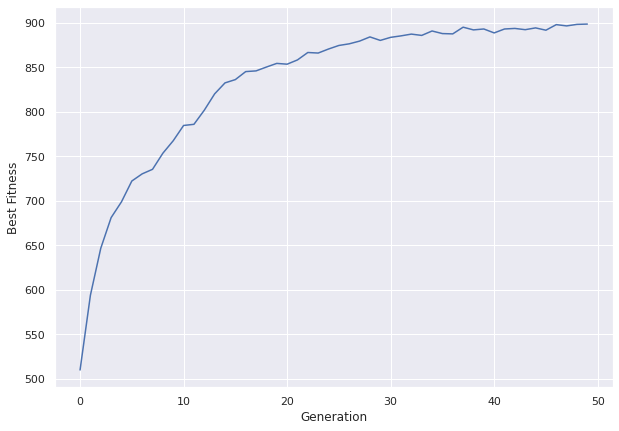

In [8]:
df = df.astype({c: float for c in df.columns if c!="prog"})
df = df.astype({"prog":str})
groupdf = df.drop(columns=["prog"]).groupby(['gen']).agg("mean").reset_index()
plt.figure(figsize=(10,7))
ax = sns.lineplot(x="gen", y="fitness", data=groupdf)
ax.set_xlabel("Generation")
ax.set_ylabel("Best Fitness")

As the phenotype of evolved classifier is simply a binary vetor. We can visualise their diversity by stacking these phenotypes and view them as an image.

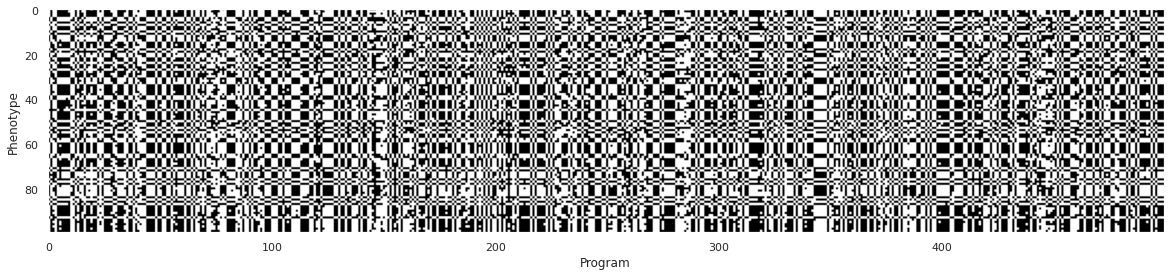

In [9]:
train_df = df.drop(["gen", "fitness","id","prog"], axis=1)
minval = np.min(train_df.values)
maxval = np.max(train_df.values)
rangeval = maxval - minval
# print(minval, rangeval)
normalized_df=(train_df-train_df.min())/(train_df.max()-train_df.min())
normalized_df
plt.figure(figsize=(20, 12))
plt.imshow(normalized_df[:500].values.T, cmap="Greys")
plt.xlabel("Program")
plt.ylabel("Phenotype")
plt.grid(False)

The example above visualises the 500 programs in the initial population and each column represents the behaviour of a program. However, even when we can visualise all evolved programs, it is impossible to detect patterns/changes or insights about the search process. 

# Visualise with PCA

Now let's try to use PCA to visualise the search process based on recorded phenotypes. PCA actually works better for classification as compared to symbolic regression. In this visualisation, we can see that programs move towards the bottom left in the later generations. However, this visualisation tells very little about how GP navigates in the search space because of the large number of points and the lack of fitness indication.

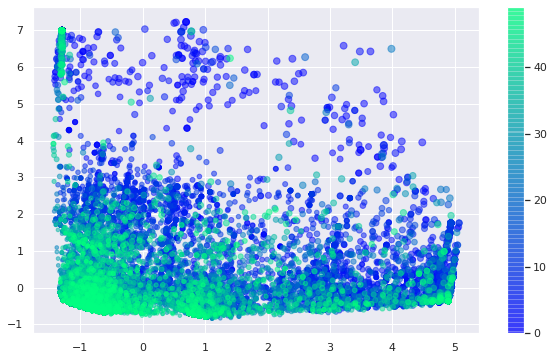

In [10]:
# normalized_df=(train_df-train_df.mean())/(train_df.std())
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
embedding = pca.fit_transform(normalized_df.values[:,:])
visualise_dimension_reduction(embedding, df)

Now let's try with SOM. We reuse the routine developed for symbolic regression and make some minor changes as we looks at maximisation instead of minimisation.

In [27]:
from minisom import MiniSom
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

som_size = 20
som = MiniSom(som_size, som_size, normalized_df.shape[1], sigma=3., learning_rate=.1, activation_distance='euclidean', topology='hexagonal',
              neighborhood_function='gaussian', random_seed=1)

ssize = normalized_df.shape[0]
data = normalized_df[:ssize].values
som.train_batch(data, ssize, verbose=True)  # random training

frequencies = som.activation_response(data)
fits = -np.inf*np.ones((som_size, som_size))
progstr = {}
gens = np.zeros((som_size, som_size))
fs = df["fitness"].values[:ssize]
pr = df["prog"].values[:ssize]
gs = df["gen"].values[:ssize]

for k in range(data[:ssize].shape[0]):
  i,j = som.winner(data[k])
  gens[i][j] += gs[k]
  if fits[i][j] == -np.inf: 
    fits[i][j] = fs[k]
    progstr[(i,j)] = pr[k]
  else:
    if fs[k] > fits[i][j]:
      fits[i][j] = fs[k]
      progstr[(i,j)] = str(pr[k])

fits[fits == -np.inf] = np.min(fits[fits != -np.inf])

 [ 50000 / 50000 ] 100% - 0:00:00 left 
 quantization error: 1.6572492236614527


Text(0.5, 1.0, 'Frequency')

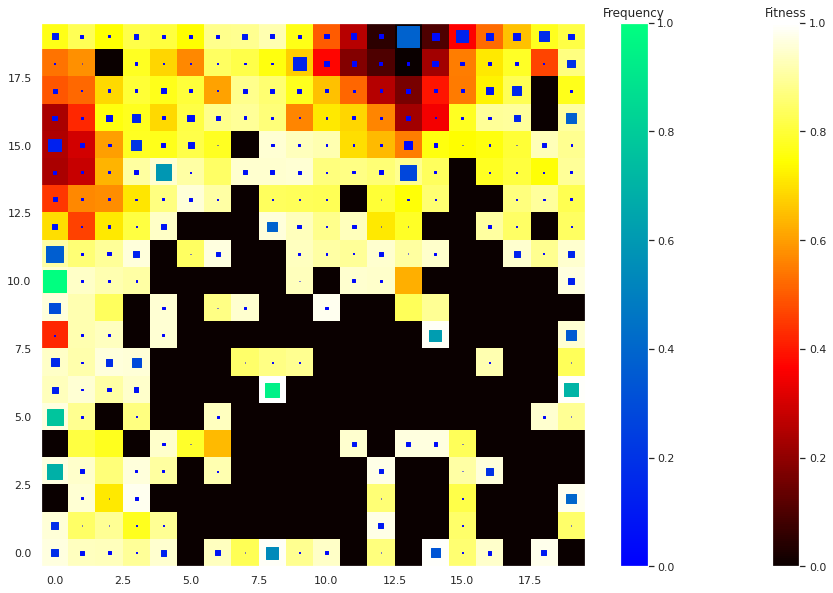

In [28]:
plt.figure(figsize=(16, 10))

fp = (frequencies - np.min(frequencies))/(np.max(frequencies) - np.min(frequencies))
scalefit = (fits - np.min(fits))/(np.max(fits) - np.min(fits))
scalegen = (gens - np.min(gens))/(np.max(gens) - np.min(gens))

plt.imshow(scalefit.T, cmap='hot', origin='lower')
# plt.pcolormesh(scalefit.T, cmap='hot') 
plt.grid(False)
clb = plt.colorbar()
clb.ax.set_title('Fitness')

xs = []
ys = []
vals = []
for i in range(som_size):
  for j in range(som_size):
    xs.append(i)
    ys.append(j)
    vals.append(500*fp[i][j])
plt.scatter(xs, ys, s=vals, c=scalegen, marker="s", cmap="winter")
clb = plt.colorbar()
clb.ax.set_title('Frequency')
# plt.text(6, 19, progstr[(6,19)])

Text(0.5, 1.0, 'Recency')

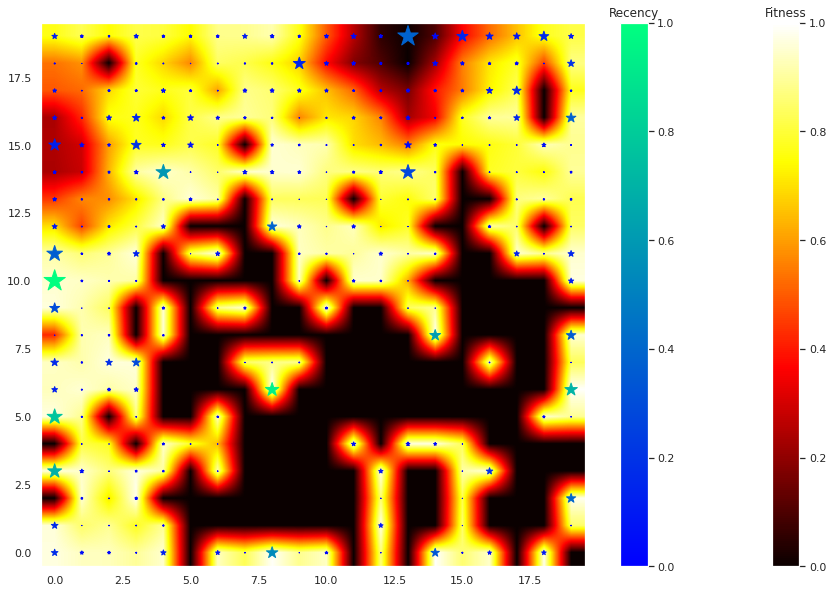

In [29]:
plt.figure(figsize=(16, 10))

fp = (frequencies - np.min(frequencies))/(np.max(frequencies) - np.min(frequencies))
scalefit = (fits - np.min(fits))/(np.max(fits) - np.min(fits))
scalegen = (gens - np.min(gens))/(np.max(gens) - np.min(gens))

plt.imshow(scalefit.T, cmap='hot', origin='lower', interpolation="bilinear") 
# plt.pcolormesh(scalefit.T, cmap='hot') 
plt.grid(False)
clb = plt.colorbar()
clb.ax.set_title('Fitness')

xs = []
ys = []
vals = []
for i in range(som_size):
  for j in range(som_size):
    xs.append(i)
    ys.append(j)
    vals.append(500*fp[i][j])
plt.scatter(xs, ys, s=vals, c=scalegen, marker="*", cmap="winter")
clb = plt.colorbar()
clb.ax.set_title('Recency')

In [42]:
fits[0,10], progstr[(0, 10)]

(932.0,
 'lt(sub(sub(add(IN24, sub(add(IN24, sub(IN26, IN52)), IN6)), IN16), add(sub(IN22, IN45), sub(IN15, IN15))), add(add(IN6, IN52), add(IN15, mul(IN24, add(add(sub(IN23, IN23), IN52), add(add(sub(IN23, IN23), IN52), mul(IN22, add(IN24, sub(IN52, IN52)))))))))')